In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import os
import yaml
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR
import torch.distributions as distributions
from tqdm import tqdm
from copy import deepcopy

In [ ]:
class RectifiedFlow:
  def euler(self,x_t,v,dt):
    x_t=x_t+v*dt
    return x_t
  def create_flow(self,x_1,t):
    x_0=torch.randn_like(x_1)
    t=t.unsqueeze(1)
    x_t=t*x_1+(1-t)*x_0
    return x_t,x_0
  def mse_loss(self,x_1,x_0,v):
    loss=F.mse_loss(x_1-x_0,v)
    return loss

In [ ]:
class TimeEmbedding(nn.Module):
  def __init__(self,embed_dim,scale=30):
    super().__init__()
    d=embed_dim//2
    w=torch.randn(d)*scale
    self.register_buffer('W',w,persistent=True)
  def forward(self,t):
    x_proj=t[:,None]*self.W[None,:]*2*math.pi
    return torch.cat([torch.sin(x_proj),torch.cos(x_proj)],dim=-1)

In [ ]:
class ScalarNet(nn.Module):
    def __init__(self, t_dim=128, hidden_dim=512):  # Larger hidden dimension
        super().__init__()

        # Enhanced time embedding
        self.time_mlp = nn.Sequential(
            TimeEmbedding(embed_dim=t_dim, scale=30),
            nn.Linear(t_dim, t_dim),
            nn.SiLU(),
            nn.Dropout(0.1),  # Add dropout for regularization
            nn.Linear(t_dim, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim)
        )

        # Deeper network with skip connections
        self.input_layer = nn.Linear(1 + t_dim, hidden_dim)

        # Residual blocks
        self.blocks = nn.ModuleList([
            self._make_block(hidden_dim) for _ in range(6)  # More layers
        ])

        self.output_layer = nn.Linear(hidden_dim, 1)

        # Better initialization
        self._initialize_weights()

    def _make_block(self, dim):
        return nn.Sequential(
            nn.Linear(dim, dim),
            nn.GroupNorm(1, dim),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(dim, dim),
            nn.GroupNorm(1, dim),
        )

    def _initialize_weights(self):
        # Initialize output layer to small values
        nn.init.zeros_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

        # Initialize other layers with proper scaling
        for m in self.modules():
            if isinstance(m, nn.Linear) and m != self.output_layer:
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h = torch.cat([x, t_emb], dim=1)

        h = F.silu(self.input_layer(h))

        # Apply residual blocks
        for block in self.blocks:
            residual = h
            h = block(h) + residual  # Skip connection
            h = F.silu(h)

        return self.output_layer(h)

#Training

In [ ]:
class EMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(EMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform EMA on different device from model if set
        if self.device is not None:
            self.module.to(device=self.device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(),
                                      model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(
            model,
            update_fn=lambda e, m: self.decay * e + (1.0 - self.decay) * m
        )

    def set(self, model):
        self._update(
            model,
            update_fn=lambda e, m: m
        )

In [ ]:
# Improved training configuration
epochs= 100  # More epochs
batch_size= 128  # Larger batch size for more stable gradients
lr= 5e-4  # Slightly higher learning rate initially
weight_decay= 1e-4  # Less regularization
ema_decay= 0.9999
grad_clip= 1.0
lr_schedule= True
step_size= 40  # Reduce LR later
gamma= 0.5 # More gradual LR reduction
lr_adjust_epoch= 25 # 学习率调整的epoch，降为原有的10%
batch_print_interval= 100 # 打印间隔，以batch为单位
device= 'cpu' # cuda、cpu、mps(only macbook)
checkpoint_save_interval= 10 # 模型保存间隔，以epoch为单位

In [ ]:
nu=2
N=100000
batch_size=64
student_t=distributions.StudentT(nu)
data=student_t.sample((N,1))
dataset=torch.utils.data.TensorDataset(data)
loader=DataLoader(dataset,batch_size,shuffle=True)
model=ScalarNet(128,256)
model.to(device)
optimiser=AdamW(model.parameters(),lr=1e-4,weight_decay=0.1)
scheduler=StepLR(optimiser,step_size=lr_adjust_epoch,gamma=0.1)
ema = EMA(model, decay=0.999, device=device)
rf=RectifiedFlow()
for epoch in range(epochs):
  pbar=tqdm(loader,desc=f'Epoch {epoch}')
  for (data,) in pbar:
    x_1=data
    t=torch.rand(x_1.size(0))
    x_t,x_0=rf.create_flow(x_1,t)
    x_t = x_t.to(device)
    x_0 = x_0.to(device)
    x_1 = x_1.to(device)
    t = t.to(device)
    optimiser.zero_grad()
    v_pred=model(x_t,t)
    loss=rf.mse_loss(x_1,x_0,v_pred)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimiser.step()
    ema.update(model)
  if epoch % 5 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'ema_state_dict': ema.state_dict(),
            'optimizer_state_dict': optimiser.state_dict(),
            'epoch': epoch,
            'loss': loss
        }, f"scalar_ckpt_{epoch}.pth")

Epoch 99: 100%|██████████| 1563/1563 [00:59<00:00, 26.32it/s]


# Sampling and Evaluation

Now let's generate new samples from the trained model and compare them with the real t-distribution.

In [ ]:
def sample_from_model(model, rf, num_samples=1000, num_steps=50, device='cuda'):
    """
    Generate samples from the trained rectified flow model
    """
    model.eval()
    with torch.no_grad():
        # Start from random noise
        x_t = torch.randn(num_samples, 1).to(device)

        # Integration step size
        dt = 1.0 / num_steps

        # Euler integration from t=0 to t=1
        for step in range(num_steps):
            t = torch.full((num_samples,), step * dt).to(device)

            # Get velocity prediction
            v_pred = model(x_t, t)

            # Euler step: x_{t+dt} = x_t + v_pred * dt
            x_t = rf.euler(x_t, v_pred, dt)

    return x_t.cpu().numpy()

# Use EMA model for sampling (better quality)
sampling_model = ema.module
sampling_model.eval()

# Generate samples using EMA model
print("Generating samples from trained EMA model...")
generated_samples = sample_from_model(sampling_model, rf, num_samples=10000, num_steps=50, device=device)

print(f"Generated {len(generated_samples)} samples")
print(f"Sample statistics:")
print(f"  Mean: {generated_samples.mean():.4f}")
print(f"  Std: {generated_samples.std():.4f}")
print(f"  Min: {generated_samples.min():.4f}")
print(f"  Max: {generated_samples.max():.4f}")

Generating samples from trained EMA model...
Generated 10000 samples
Sample statistics:
  Mean: -0.0356
  Std: 1.8863
  Min: -26.6117
  Max: 22.1964


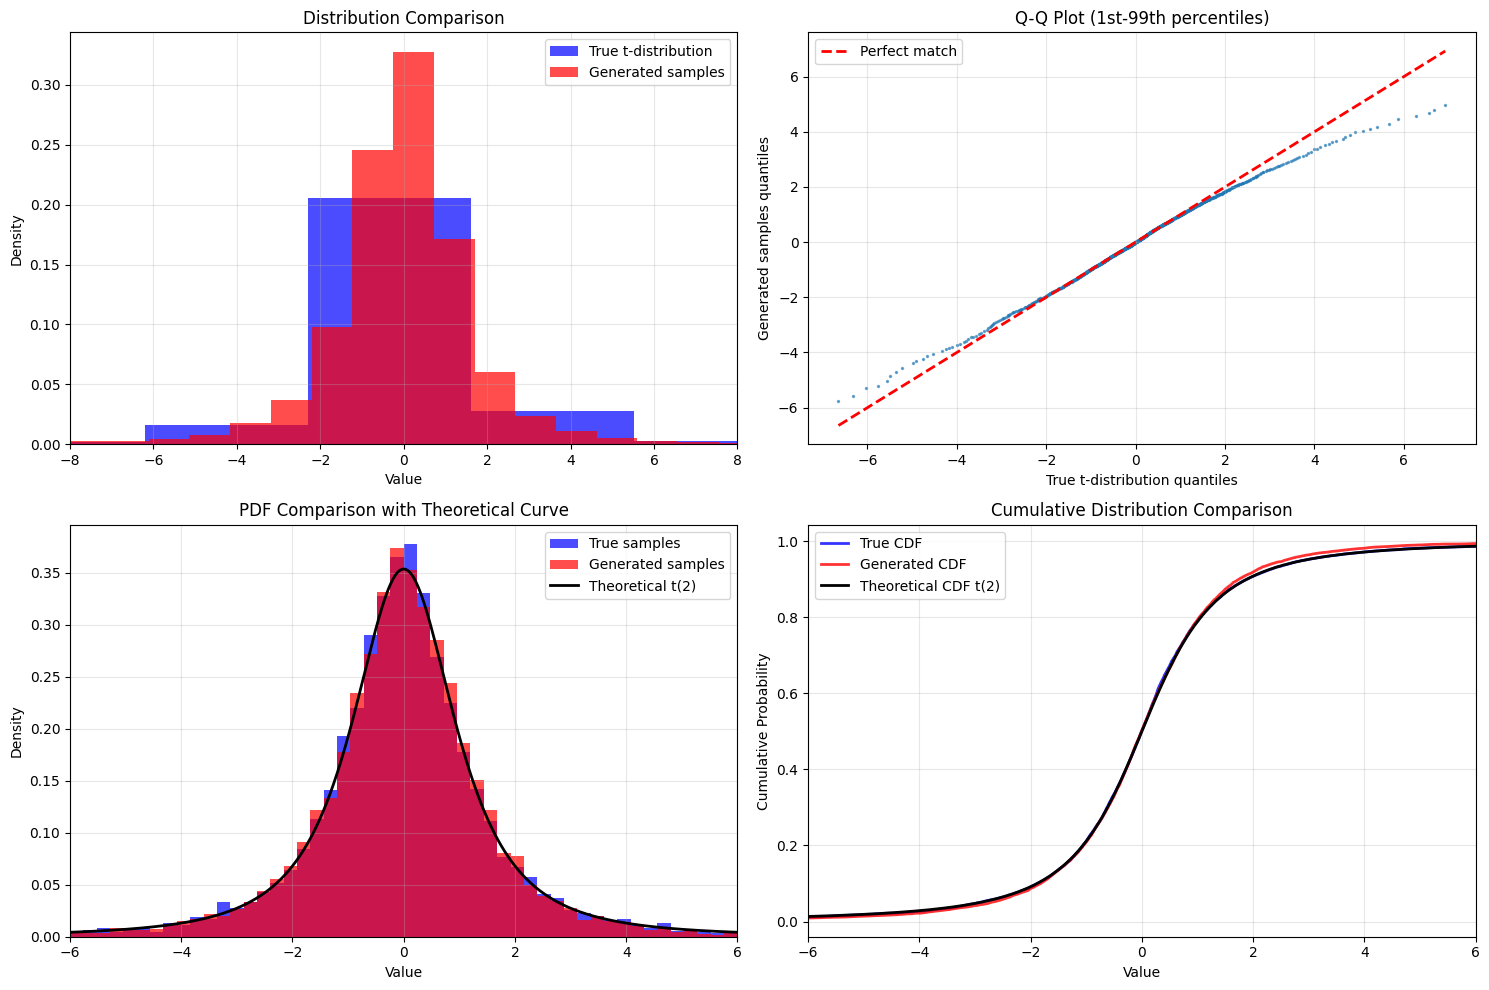

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Generate true t-distribution samples for comparison
true_samples = student_t.sample((10000,)).numpy()

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram comparison
axes[0, 0].hist(true_samples.flatten(), bins=50, alpha=0.7, density=True, label='True t-distribution', color='blue')
axes[0, 0].hist(generated_samples.flatten(), bins=50, alpha=0.7, density=True, label='Generated samples', color='red')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Distribution Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
# Limit the range to focus on the main distribution
axes[0, 0].set_xlim(-8, 8)

# 2. Q-Q plot - Fixed scaling issue
true_sorted = np.sort(true_samples.flatten())
gen_sorted = np.sort(generated_samples.flatten())

# Use percentiles to avoid extreme outliers affecting the plot
percentiles = np.linspace(1, 99, 1000)  # 1st to 99th percentile
true_quantiles = np.percentile(true_sorted, percentiles)
gen_quantiles = np.percentile(gen_sorted, percentiles)

axes[0, 1].scatter(true_quantiles, gen_quantiles, alpha=0.6, s=2)
# Perfect correlation line
min_val = min(true_quantiles.min(), gen_quantiles.min())
max_val = max(true_quantiles.max(), gen_quantiles.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect match')
axes[0, 1].set_xlabel('True t-distribution quantiles')
axes[0, 1].set_ylabel('Generated samples quantiles')
axes[0, 1].set_title('Q-Q Plot (1st-99th percentiles)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. PDF overlay with theoretical curve
x_range = np.linspace(-6, 6, 1000)
true_pdf = stats.t.pdf(x_range, df=nu)

axes[1, 0].hist(true_samples.flatten(), bins=50, alpha=0.7, density=True, label='True samples', color='blue', range=(-6, 6))
axes[1, 0].hist(generated_samples.flatten(), bins=50, alpha=0.7, density=True, label='Generated samples', color='red', range=(-6, 6))
axes[1, 0].plot(x_range, true_pdf, 'k-', lw=2, label=f'Theoretical t({nu})')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('PDF Comparison with Theoretical Curve')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(-6, 6)

# 4. Cumulative distribution comparison
x_eval = np.linspace(-6, 6, 1000)
true_cdf_empirical = np.searchsorted(true_sorted, x_eval) / len(true_sorted)
gen_cdf_empirical = np.searchsorted(gen_sorted, x_eval) / len(gen_sorted)
theoretical_cdf = stats.t.cdf(x_eval, df=nu)

axes[1, 1].plot(x_eval, true_cdf_empirical, 'b-', alpha=0.8, label='True CDF', linewidth=2)
axes[1, 1].plot(x_eval, gen_cdf_empirical, 'r-', alpha=0.8, label='Generated CDF', linewidth=2)
axes[1, 1].plot(x_eval, theoretical_cdf, 'k-', lw=2, label=f'Theoretical CDF t({nu})')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Cumulative Distribution Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(-6, 6)

plt.tight_layout()
plt.show()